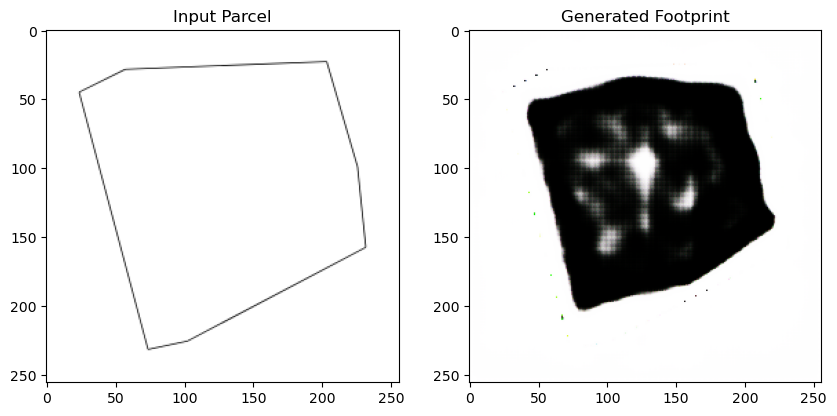

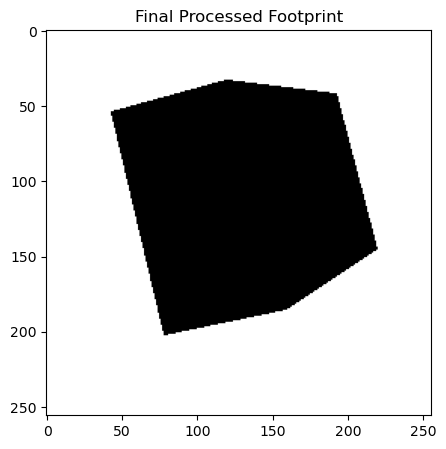

Final footprint image saved to the database.


In [27]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import mysql.connector

# Paths to the generator model and test image
generator_path = r'Shape_generator_epoch_100.h5'  # Update path as needed
test_image_path = r'shape_detection_test_image/Parcel_53.png'  # Update path as needed

# Paths to save the intermediate images
input_save_path = r'input_image.png'
output_save_path = r'generated_image.png'

# Database connection setup
conn = mysql.connector.connect(
    host="localhost",
    user="root",  # Replace with your MySQL username
    password="1111",  # Replace with your MySQL password
    database="apexa_db"
)
cursor = conn.cursor()

# Load the pre-trained generator
generator = load_model(generator_path, compile=False)

# Function to preprocess the test image
def preprocess_image(image_path):
    """
    Load and preprocess a test image for the generator.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  # Adjust channels as needed
    img = tf.image.resize(img, [256, 256])  # Resize to match the model's input size
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Preprocess the test image
input_image = preprocess_image(test_image_path)

# Add a batch dimension for the generator
input_image = tf.expand_dims(input_image, axis=0)

# Generate room split using the pre-trained model
predicted_split = generator(input_image, training=False)

# Save the input and output images locally
tf.keras.preprocessing.image.save_img(
    input_save_path, (input_image[0] + 1) * 127.5  # Convert back to [0, 255] range
)
tf.keras.preprocessing.image.save_img(
    output_save_path, (predicted_split[0] + 1) * 127.5  # Convert back to [0, 255] range
)

# Display the input and output images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Parcel")
plt.imshow((input_image[0] + 1) / 2)  # De-normalize to [0, 1] range

plt.subplot(1, 2, 2)
plt.title("Generated Footprint")
plt.imshow((predicted_split[0] + 1) / 2)  # De-normalize to [0, 1] range
plt.show()


# --- Processing the generated footprint image ---

# Read the generated footprint image in grayscale
img = cv2.imread(output_save_path, cv2.IMREAD_GRAYSCALE)

# Check if image loaded successfully
if img is None:
    print(f"Error: Could not load image from {output_save_path}. Check the file path and permissions.")
else:
    # Step 1: Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Step 2: Thresholding to make the shape distinct
    _, thresholded = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

    # Step 3: Morphological operations to improve shape clarity
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    # Step 4: Use Canny edge detection to highlight the edges
    edges = cv2.Canny(closed, 50, 150)

    # Step 5: Find contours based on the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 6: Draw simplified, straighter contours on a blank canvas
    sharp_image = np.zeros_like(img)
    for contour in contours:
        # Approximate the contour to a polygon to straighten lines
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust 0.01 for more or less smoothing
        approx = cv2.approxPolyDP(contour, epsilon, True)
        cv2.drawContours(sharp_image, [approx], -1, (255), thickness=cv2.FILLED)

    # Invert the sharp image to get black shape on white background
    final_image = cv2.bitwise_not(sharp_image)

    # Save the final processed footprint image
    _, encoded_image = cv2.imencode('.png', final_image)
    final_image_blob = encoded_image.tobytes()

    # # Save the final image to the database
    # email = "apexa123@gmail.com"  # Replace with dynamic user email if available
    # insert_query = "INSERT INTO user_input_image (image_data, email) VALUES (%s, %s)"
    # cursor.execute(insert_query, (final_image_blob, email))
    # conn.commit()

# Display the final processed footprint image
plt.figure(figsize=(10, 5))
plt.title("Final Processed Footprint")
plt.imshow(final_image, cmap='gray')
plt.show()

import mysql.connector

def insert_image_into_user_input_image_table(image_path, email):
    """
    Insert an image into the 'user_input_image' table in the database.
    Args:
        image_path (str): Path to the image file.
        email (str): Email associated with the image.
    """
    try:

        # Read the image as binary data
        with open(image_path, 'rb') as file:
            binary_data = file.read()
        # Insert image into the table
        
        insert_query = """
        INSERT INTO user_input_image (email, image_data)
        VALUES (%s, %s)
        """
        cursor.execute(insert_query, (email, binary_data))
        conn.commit()

    finally:
        # Close the database connection
        if cursor:
            cursor.close()
        if conn:
            conn.close()

       
# Example usage
image_path = "shape_detection_test_image/footprint_53.png"  # Replace with the actual image file path
email = "manjitha@example.com"  # Replace with the user's email
insert_image_into_user_input_image_table(image_path, email)

    

print("Final footprint image saved to the database.")



In [19]:
#check code